#### Multiomic Results
##### Now we are going to find latent representations using two layers of data. 
Load the 3 layers and drop the samples that are not present on every dataset

Use the data processing function from Models to get the data with variance filtered features and min max normalized, as well as the swap noisy data, for both layers. We will use the concatenetade layer as well for analysis.

In [3]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
sns.set()

# Load Data
X_brca_methyl_data = pd.read_csv('./BRCA_methylation.txt', sep=',', index_col=0) # Dataset has Donor ID as first column
X_brca_mRNA_data = pd.read_csv('./BRCA_mRNA.txt', sep=',', index_col=0) # Dataset has Donor ID as first column
X_brca_CNA_data = pd.read_csv('./BRCA_CNA.txt', sep=',' ,index_col=0) # Dataset has Donor ID as first column
y_brca_data = pd.read_csv('./BRCA_Clinical.txt', sep=',', index_col=0, names=["Label"]) # Dataset has Donor ID on first column and Label on second column.

X_brca_methyl_filtered = X_brca_methyl_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01"], axis=1)
X_brca_mRNA_filtered = X_brca_mRNA_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=1)
X_brca_CNA_filtered = X_brca_CNA_data.drop(["TCGA-AR-A0U1-01"], axis=1)
y_brca_filtered = y_brca_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=0)


X_train_first_norm, X_train_second_norm, X_swapped_first_norm, X_swapped_second_norm, X_test_first_norm, X_test_second_norm, X_train_concat, X_swapped_concat, X_test_concat, y_train, y_test, y_train_oh, y_test_oh \
    = Models.prepare_datasets(X_brca_methyl_filtered.T,X_brca_mRNA_filtered.T, y_brca_filtered, test_size=0.2, swap_noise=0.15)


swapping: 20 rows.


In [4]:
X_train_second_norm.shape

(130, 5118)

In [5]:
import importlib
importlib.reload(Models)

<module 'Models' from 'F:\\Documentacion\\Data Science\\Python\\Notebooks\\oss-stage-2019\\Multiomic Dataset\\Models.py'>

We will use the Methylation and mRNA layers. The methylation layer consists of 165 samples of 14299 features. The mRNA layer consists of 166 samples of 20472 features. After droping the missing samples and selecting the top 25% of features with higher variance, the methylation and CNA datasets result in 130 training samples of 5118 features (0.036 samples to features ratio) and 130 training samples of 5475 features (0.023 samples to features ratio), respectively. We will visualize each layer's first two principal components after performing PCA

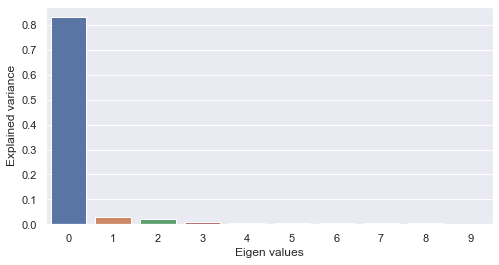

PCA on single-modal explained variance ratio: 0.9195237495686648


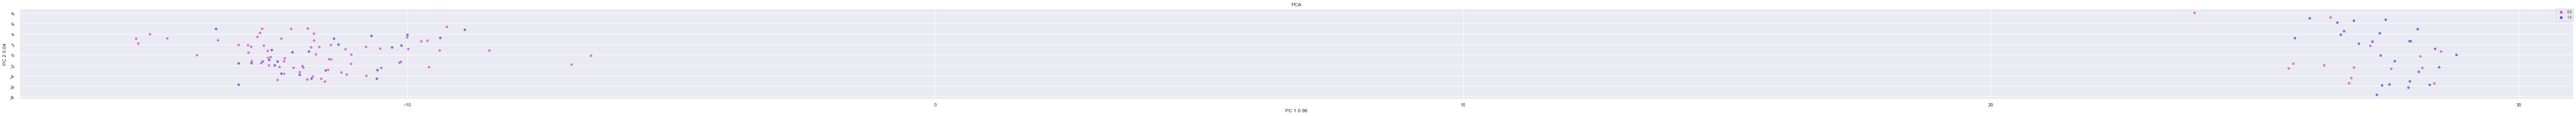

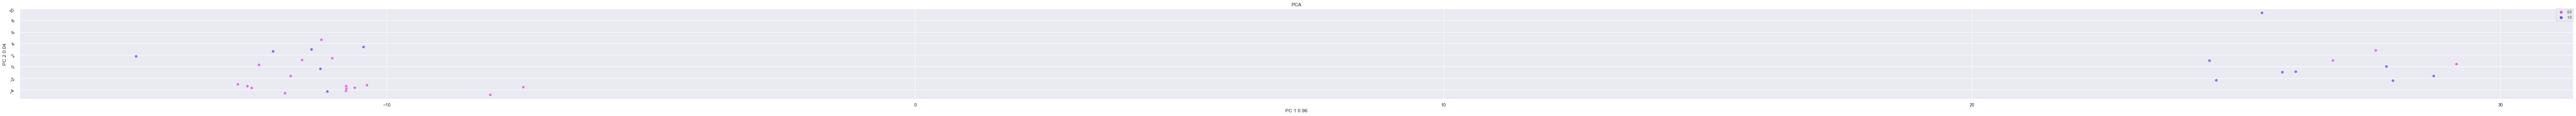

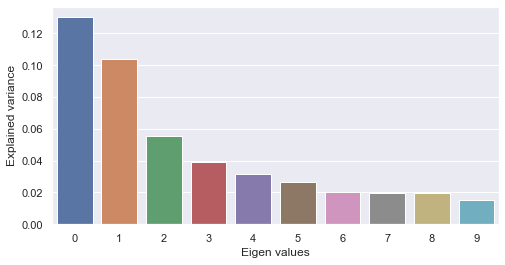

PCA on single-modal explained variance ratio: 0.46264634784462083


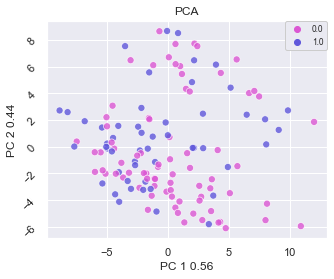

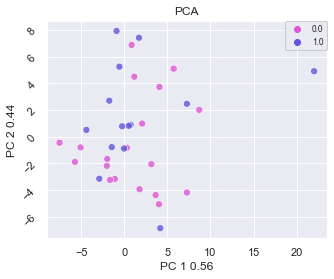

PCA


In [6]:
X_latent_pca, X_latent_pca_test = Models.perform_PCA(X_train_first_norm, y_train, X_test_first_norm, y_test)
X_latent_pca, X_latent_pca_test = Models.perform_PCA(X_train_second_norm, y_train, X_test_second_norm, y_test)
print("PCA")

We can see a clear difference between both datasets. Methylation shows two groups of data with overlapped classes, while the CNA dataset shows a single group of very difuse, overlapped data. Let's visualize the concatenation of both datasets.

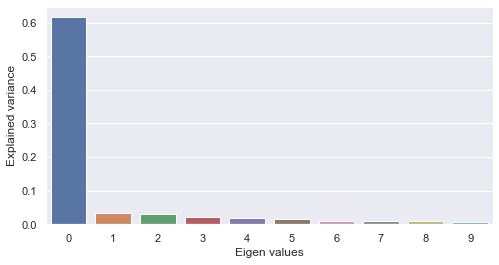

PCA on single-modal explained variance ratio: 0.7700891771896972


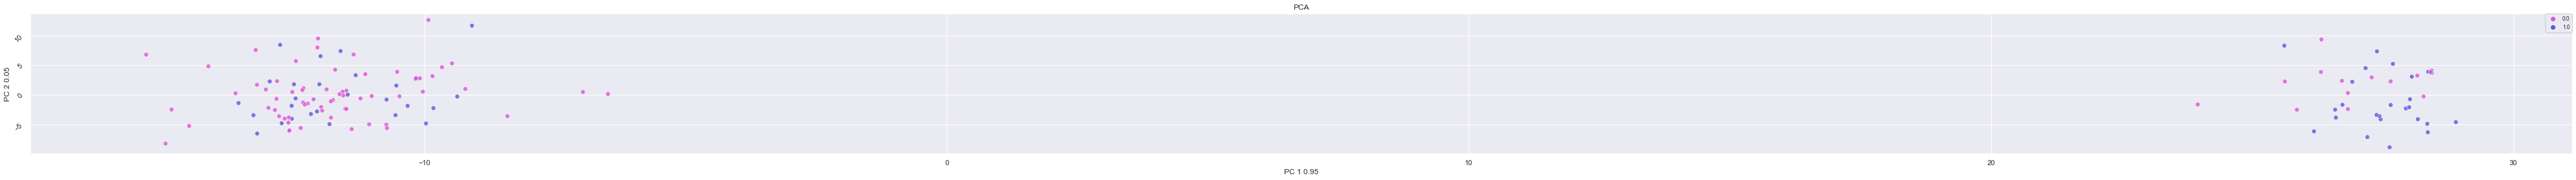

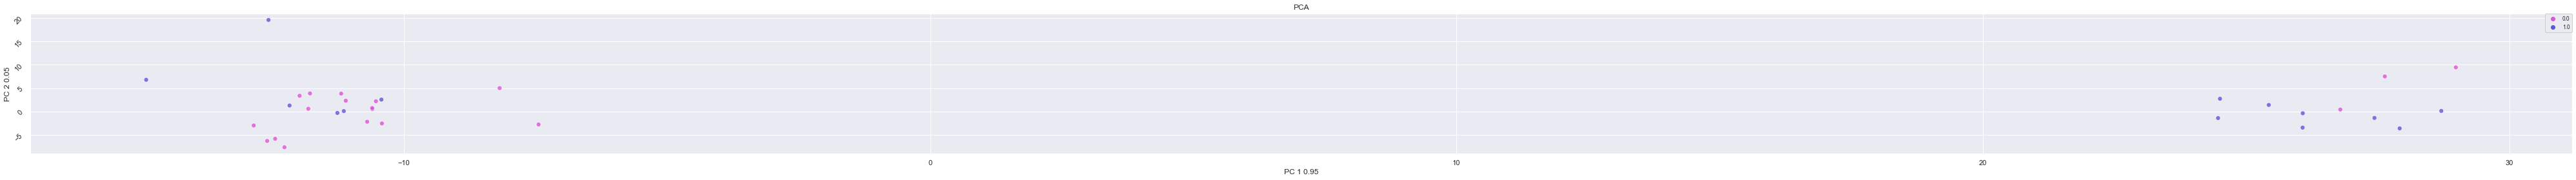

PCA


In [20]:
X_latent_pca, X_latent_pca_test = Models.perform_PCA(X_train_concat, y_train, X_test_concat, y_test)
print("PCA")

The result is similar to the methylation layer, we can see two groups of overlapped data.

Next, we will try a bimodal Autoencoder model to get a latent representation of both layers. The architecture of the model can be visualized in [Insertar Figura con la estructura del Multi-input AE]:

The hyperparameters found by grid search are, dropout=0.25, l1=0.0000001, l2=0.000003, and the loss weight parameter for each layer, that suggests that one of the layers is "more important" than the other, mu=0.3.

On the other hand, we are going to train a single-input AE with the concatenated datasets, to compare the models later. The hyperparameters for this model are dropout=0, l1=0.0000001, l2=0.000005.  

Finally, we encode each model's training and test sets.

Compression: 86.93

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00081: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00086: early stopping


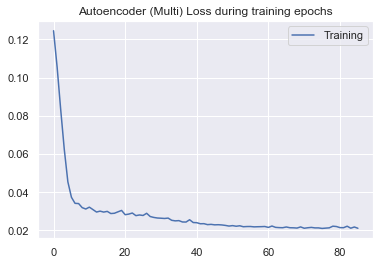

0.02113637227851611
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Compression: 86.93

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00087: early stopping


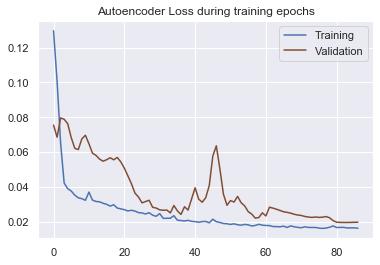

In [7]:
## Build and Train Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_multi_autoencoder([X_train_first_norm,X_train_second_norm],
                                                              [X_train_first_norm,X_train_second_norm],
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.0000001,0.0000005),
                                                              dropout=0.25,
                                                              epochs=200,
                                                              mu=0.3)

keras.utils.plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)        

## Encode datasets
X_latent_multi_ae = Models.encode_dataset([X_train_first_norm,X_train_second_norm], encoder)
X_latent_test_multi_ae = Models.encode_dataset([X_test_first_norm,X_test_second_norm], encoder)

## Build and Train Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_train_concat,
                                                              X_train_concat,
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.0000001,0.000005),
                                                              dropout=0,
                                                              epochs=200,
                                                              )

## Encode datasets
X_latent_ae = Models.encode_dataset(X_train_concat, encoder)
X_latent_test_ae = Models.encode_dataset(X_test_concat, encoder)

With the 100-dimensional bottleneck layer, we get a compression rate of nearly 87 times.

Now let's visualize the latent spaces with PCA.

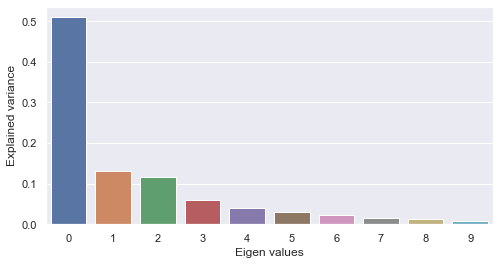

PCA on single-modal explained variance ratio: 0.949272871017456


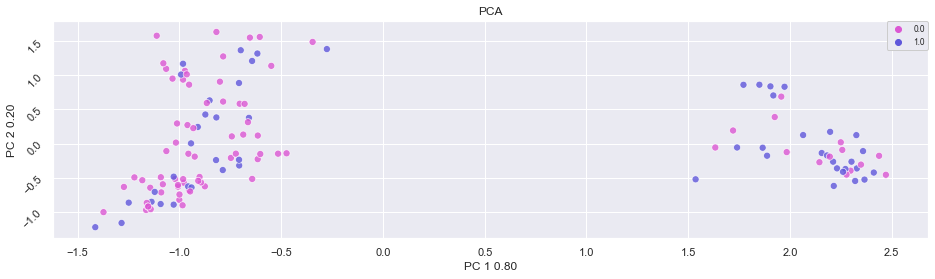

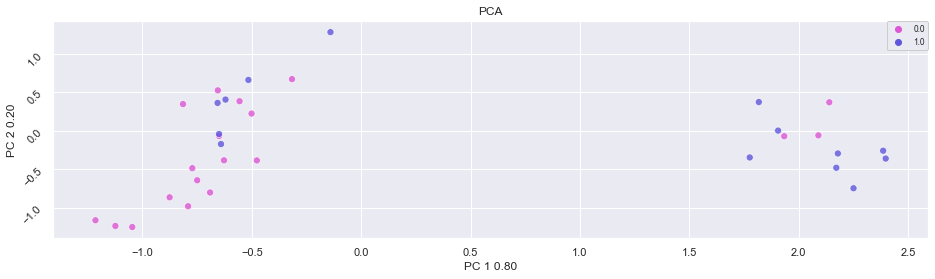

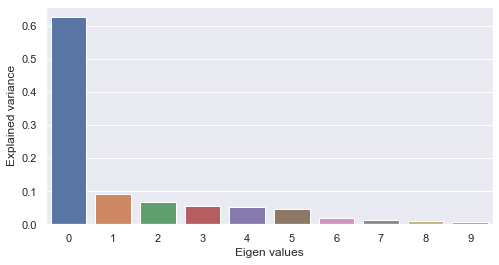

PCA on single-modal explained variance ratio: 0.9851400852203369


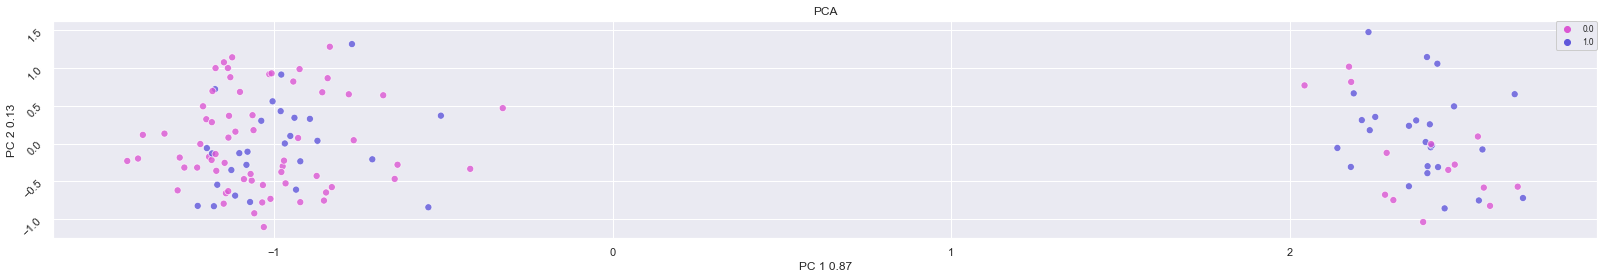

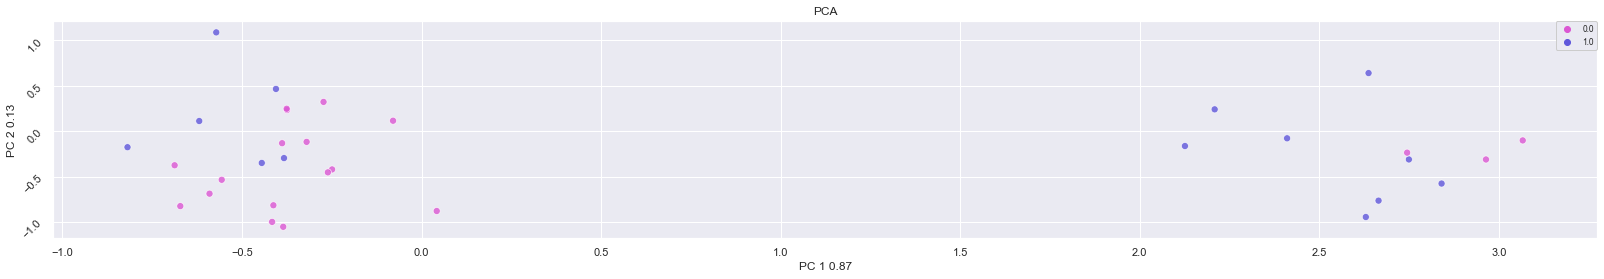

____


In [8]:
Models.perform_PCA(X_latent_multi_ae, y_train, X_latent_test_multi_ae, y_test)
Models.perform_PCA(X_latent_ae, y_train, X_latent_test_ae, y_test)
print("____")

We start noticing some differences. For the multi-input after applying PCA, we get as result a first principal component of approximately 55% of explained variance, and followed by a series of lower principal componets. Visualizing the first two principal components shows two groups of data points, with overlapped classes. For the concatenated dataset we get a slightly lower first principal component. The data is dividid in two highly overlapped groups as well.

Results for Multi-AE: 

Best score for training data: 0.7076923076923076 

Best C: 0.5 



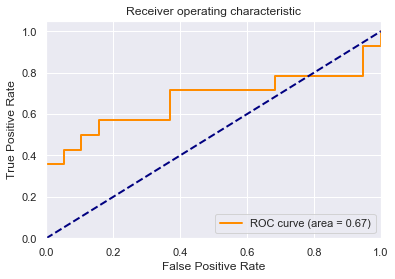

[[17  2]
 [ 7  7]]


              precision    recall  f1-score   support

           0       0.71      0.89      0.79        19
           1       0.78      0.50      0.61        14

    accuracy                           0.73        33
   macro avg       0.74      0.70      0.70        33
weighted avg       0.74      0.73      0.71        33

Training set score for Logistic Regression: 0.723077
Testing  set score for Logistic Regression: 0.727273
Best score for training data: 0.7 

Best C: 0.5 

Best Gamma: 0.05 



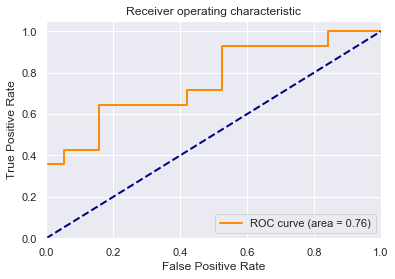

[[16  3]
 [ 7  7]]


              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.70      0.50      0.58        14

    accuracy                           0.70        33
   macro avg       0.70      0.67      0.67        33
weighted avg       0.70      0.70      0.69        33

Training set score for SVM: 0.707692
Testing  set score for SVM: 0.696970
Best score for training data: 0.676923076923077 

Best #estimators: 80 

Best max depth: 11 



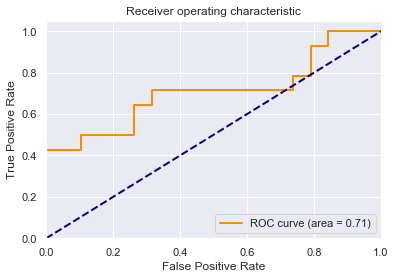

[[16  3]
 [ 7  7]]


              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.70      0.50      0.58        14

    accuracy                           0.70        33
   macro avg       0.70      0.67      0.67        33
weighted avg       0.70      0.70      0.69        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.696970


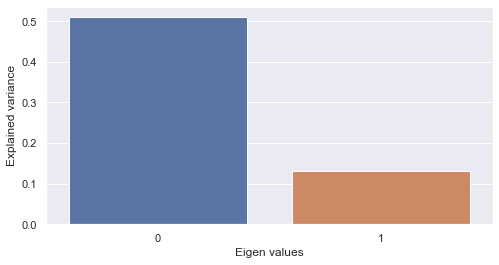

PCA on single-modal explained variance ratio: 0.6398380398750305


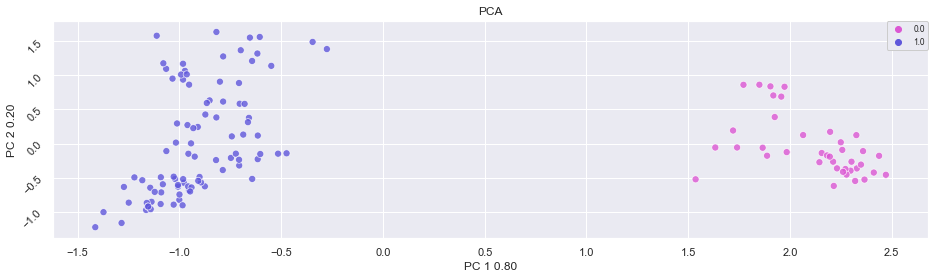

2 clusters -  silhoutte score: 0.48313888907432556 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.32558247447013855 - mutual information: 0.06141368889910484
4 clusters -  silhoutte score: 0.29373204708099365 - mutual information: 0.08690417878792135


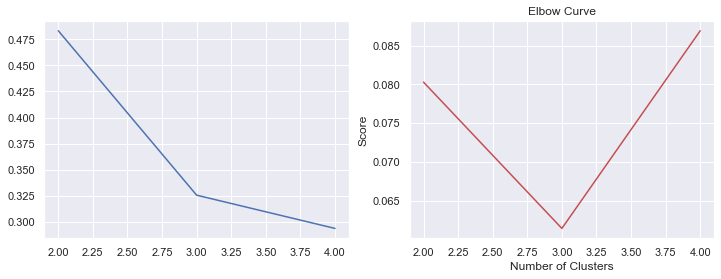

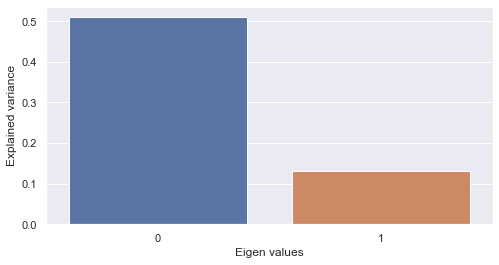

PCA on single-modal explained variance ratio: 0.6398380398750305


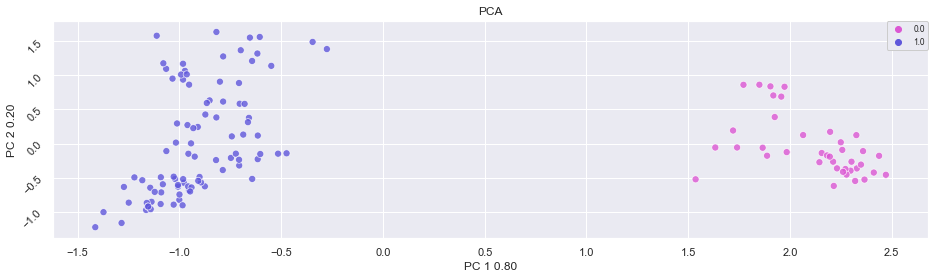

2 clusters -  silhoutte score: 0.48313888907432556 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.4428722560405731 - mutual information: 0.11110830787035159
4 clusters -  silhoutte score: 0.30456265807151794 - mutual information: 0.08744302269839044


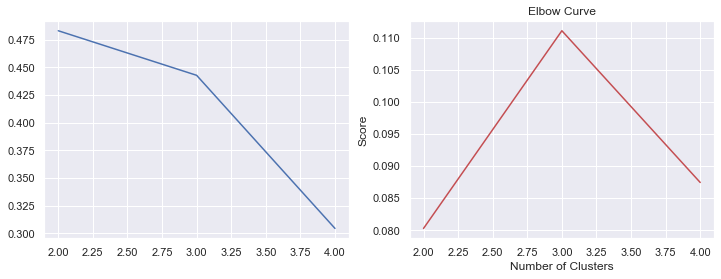

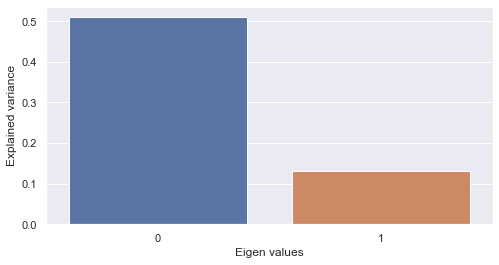

PCA on single-modal explained variance ratio: 0.6398380398750305


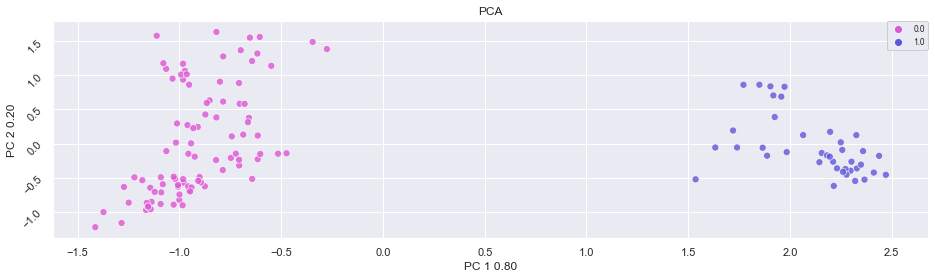

2 clusters -  silhoutte score: 0.48313888907432556 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.32611599564552307 - mutual information: 0.060589725412077924
4 clusters -  silhoutte score: 0.2945047914981842 - mutual information: 0.08662405578825096


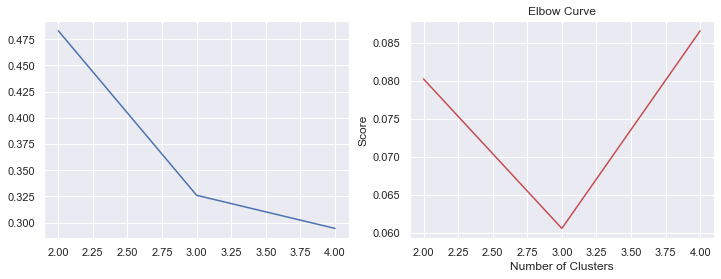

Results for AE: 

Best score for training data: 0.7 

Best C: 0.5 



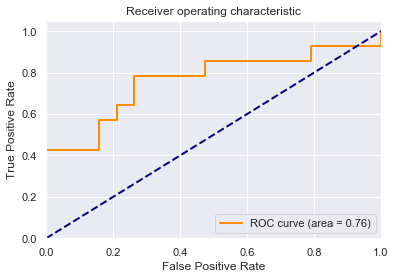

[[18  1]
 [ 8  6]]


              precision    recall  f1-score   support

           0       0.69      0.95      0.80        19
           1       0.86      0.43      0.57        14

    accuracy                           0.73        33
   macro avg       0.77      0.69      0.69        33
weighted avg       0.76      0.73      0.70        33

Training set score for Logistic Regression: 0.753846
Testing  set score for Logistic Regression: 0.727273
Best score for training data: 0.7 

Best C: 0.5 

Best Gamma: 0.1 



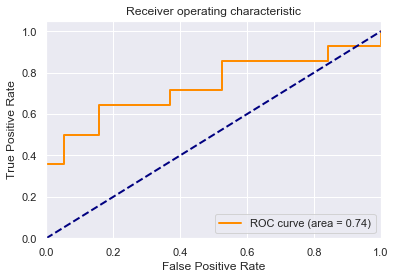

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for SVM: 0.684615
Testing  set score for SVM: 0.727273
Best score for training data: 0.7 

Best #estimators: 115 

Best max depth: 10 



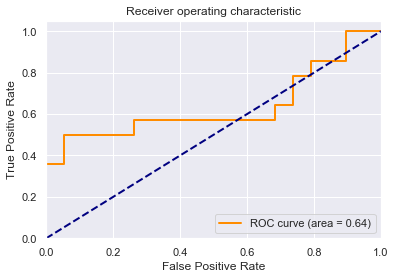

[[18  1]
 [ 7  7]]


              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.88      0.50      0.64        14

    accuracy                           0.76        33
   macro avg       0.80      0.72      0.73        33
weighted avg       0.79      0.76      0.74        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.757576


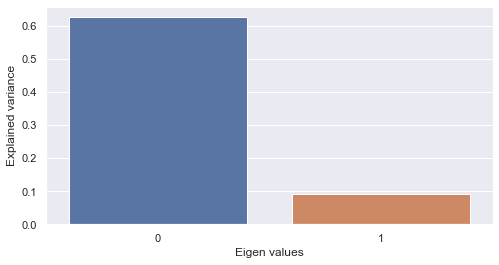

PCA on single-modal explained variance ratio: 0.7157430648803711


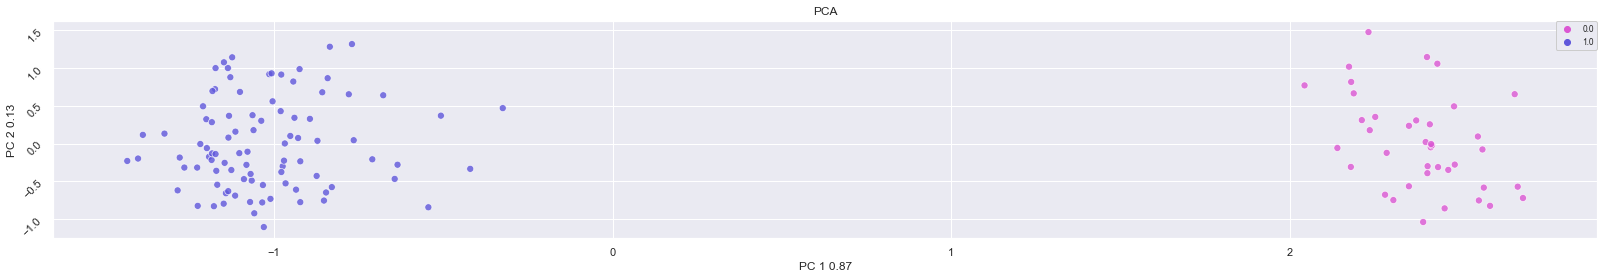

2 clusters -  silhoutte score: 0.5596210360527039 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.2995363175868988 - mutual information: 0.06002105443573342
4 clusters -  silhoutte score: 0.20586422085762024 - mutual information: 0.08074397553541263


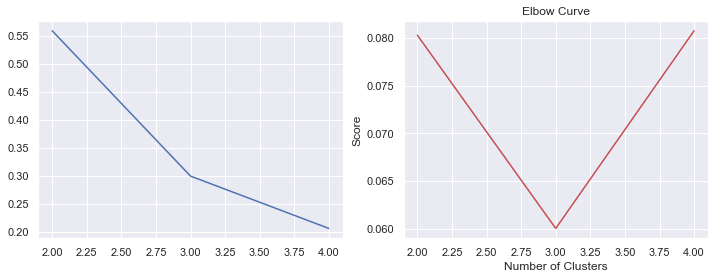

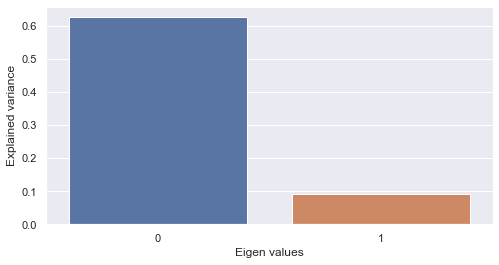

PCA on single-modal explained variance ratio: 0.7157430648803711


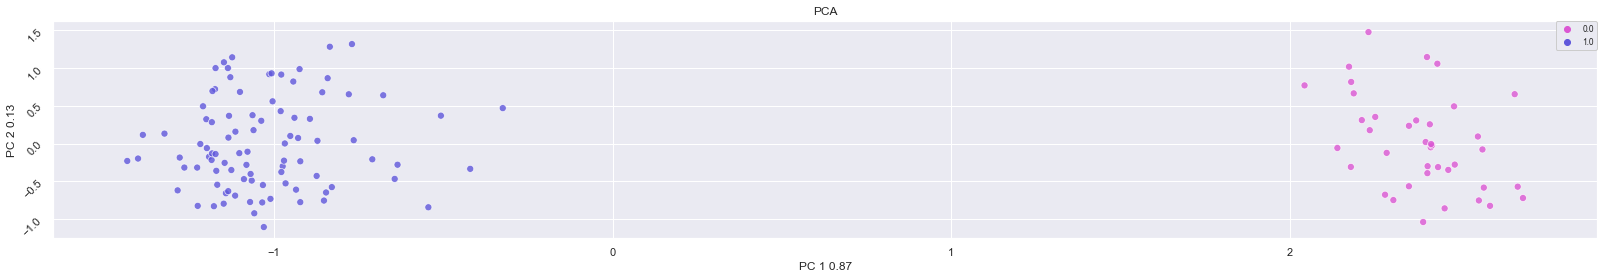

2 clusters -  silhoutte score: 0.5596210360527039 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.4581913650035858 - mutual information: 0.10426316095473105
4 clusters -  silhoutte score: 0.20919376611709595 - mutual information: 0.082077970159413


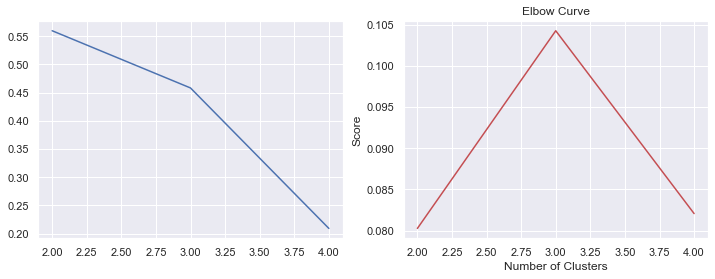

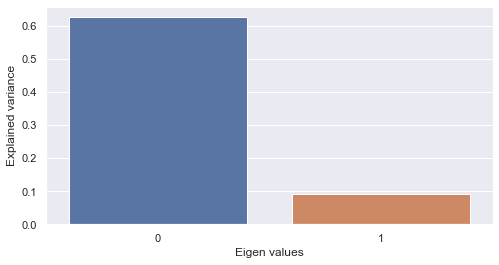

PCA on single-modal explained variance ratio: 0.7157430648803711


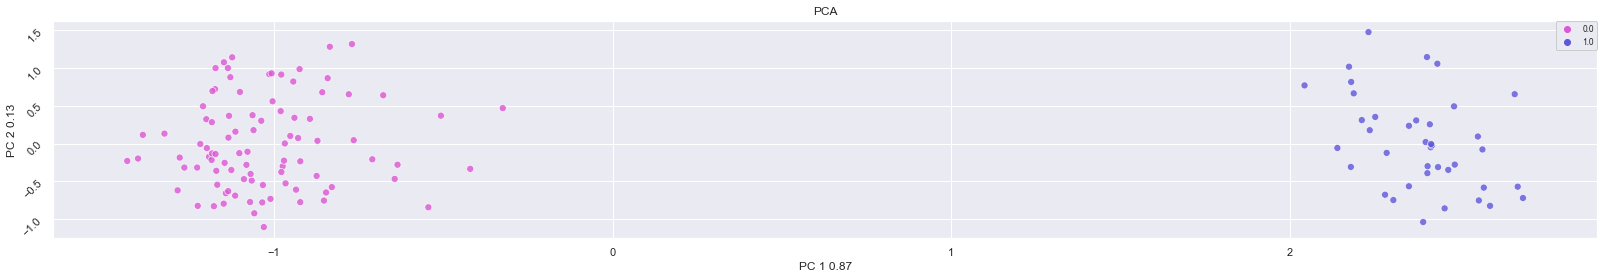

2 clusters -  silhoutte score: 0.5596210360527039 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.27955108880996704 - mutual information: 0.06487618849340038
4 clusters -  silhoutte score: 0.17914165556430817 - mutual information: 0.08656343598107118


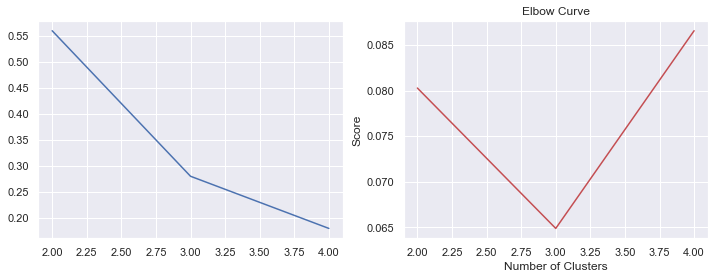

,LR accuracy,SVM accuracy,RF accuracy,LR ROC-AUC,SVM ROC-AUC,RF ROC-AUC,KMeans Silhouette,Spectral Silhouette,Hierarchical Silhouette,KMeans MI,Spectral MI,Hierarchical MI
Multi-AE,0.727273,0.696970,0.696970,0.669173,0.759398,0.706767,0.483139,0.483139,0.483139,0.086904,0.087443,0.086624
AE,0.727273,0.727273,0.757576,0.763158,0.736842,0.635338,0.559621,0.559621,0.559621,0.080744,0.082078,0.086563


No classifier: 0.5757575757575758


In [9]:
## MULTI AE ##
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_latent_multi_ae, X_latent_test_multi_ae, np.ravel(y_train), np.ravel(y_test), model_type="Multi-AE")
### CLUSTERING ###
clustering = Models.cluster(X_latent_multi_ae,np.ravel(y_train), model_type="Multi-AE")

multi_ae_scores = pd.DataFrame([classify + clustering], index=['Multi-AE'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    

## CONCATENATED AE ##
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_latent_ae, X_latent_test_ae, np.ravel(y_train), np.ravel(y_test), model_type="AE")
### CLUSTERING ###
clustering = Models.cluster(X_latent_ae,np.ravel(y_train), model_type="AE")


ae_scores = pd.DataFrame([classify + clustering], index=['AE'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
display(pd.concat([multi_ae_scores, ae_scores]))
print(f"No classifier: {y_test.iloc[:,0].value_counts()[0]/len(y_test)}")

REVIEW! The Multi-AE overall performance is better for all but Mutual Information, where the single AE performs slightly better, even though both models performance on this metric is low. 


Next, we will use the noisy datasets to train the same single and multi-input AE models, and see if we can improve our results. The architecture of the AEs is the same as before, but the hyperparameters need to be tuned again. The resulting hyperparameters for the multi-DAE are dropout=0, l1=, l2=, mu=0.2

Compression: 86.93

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 00044: early stopping


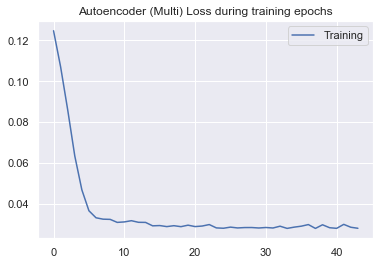

0.02801277717718711
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Compression: 86.93

Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00128: early stopping


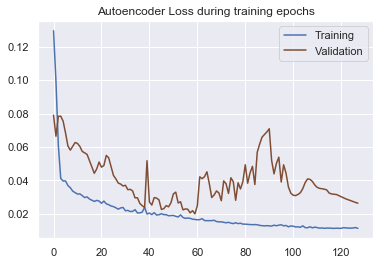

In [10]:
## Build and Train Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_multi_autoencoder([X_swapped_first_norm,X_swapped_second_norm],
                                                              [X_train_first_norm,X_train_second_norm],
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.0000001,0.0000005),
                                                              dropout=0.25,
                                                              epochs=200,
                                                              mu=0.3)

keras.utils.plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)        

## Encode datasets
X_latent_multi_dae = Models.encode_dataset([X_train_first_norm,X_train_second_norm], encoder)
X_latent_test_multi_dae = Models.encode_dataset([X_test_first_norm,X_test_second_norm], encoder)

## Build and Train Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_swapped_concat,
                                                              X_train_concat,
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.0000001,0.000005),
                                                              dropout=0,
                                                              epochs=200,
                                                              )

## Encode datasets
X_latent_dae = Models.encode_dataset(X_train_concat, encoder)
X_latent_test_dae = Models.encode_dataset(X_test_concat, encoder)

The compression is the same as we kept the same encoding dimension. Let's visualize them using PCA.

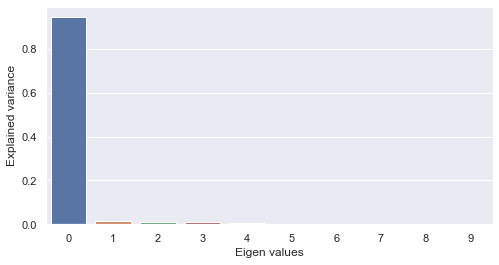

PCA on single-modal explained variance ratio: 0.9953168034553528


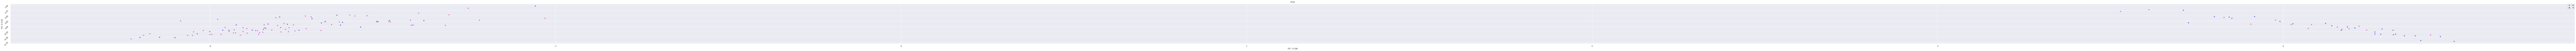

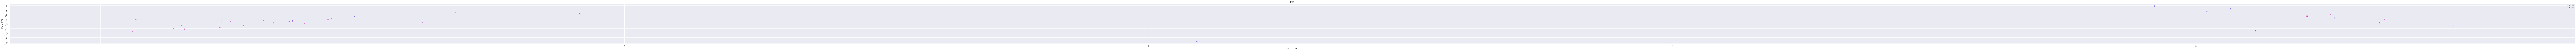

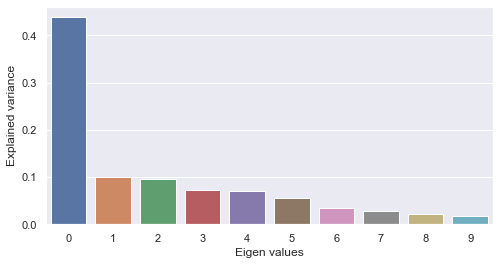

PCA on single-modal explained variance ratio: 0.9353809952735901


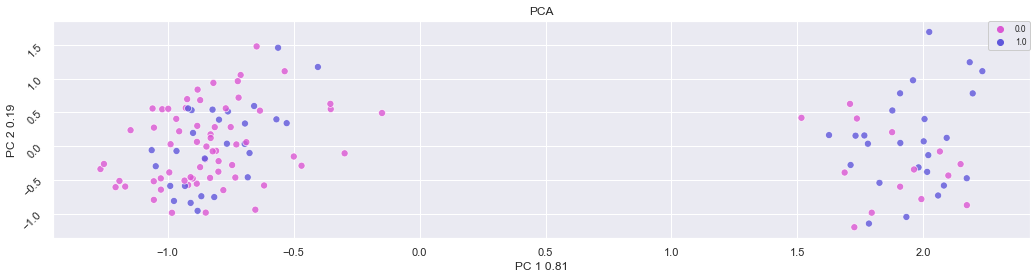

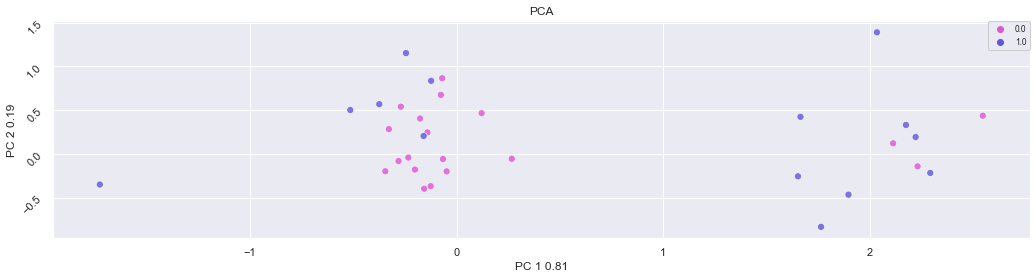

____


In [11]:
Models.perform_PCA(X_latent_multi_dae, y_train, X_latent_test_multi_dae, y_test)
Models.perform_PCA(X_latent_dae, y_train, X_latent_test_dae, y_test)
print("____")

And then we evaluate both latent spaces.

Results for Multi-DAE: 

Best score for training data: 0.6923076923076923 

Best C: 0.5 



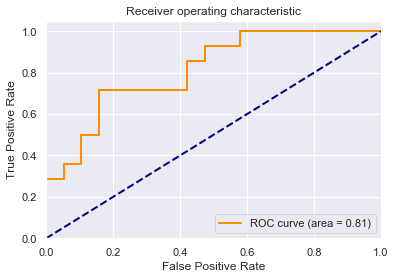

[[19  0]
 [11  3]]


              precision    recall  f1-score   support

           0       0.63      1.00      0.78        19
           1       1.00      0.21      0.35        14

    accuracy                           0.67        33
   macro avg       0.82      0.61      0.56        33
weighted avg       0.79      0.67      0.60        33

Training set score for Logistic Regression: 0.700000
Testing  set score for Logistic Regression: 0.666667
Best score for training data: 0.6923076923076923 

Best C: 0.1 

Best Gamma: 0.05 



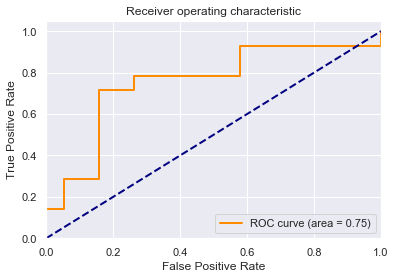

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for SVM: 0.684615
Testing  set score for SVM: 0.727273
Best score for training data: 0.6692307692307692 

Best #estimators: 120 

Best max depth: 8 



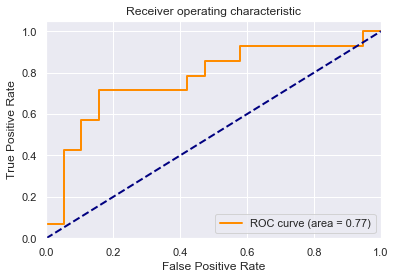

[[18  1]
 [12  2]]


              precision    recall  f1-score   support

           0       0.60      0.95      0.73        19
           1       0.67      0.14      0.24        14

    accuracy                           0.61        33
   macro avg       0.63      0.55      0.48        33
weighted avg       0.63      0.61      0.52        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.606061


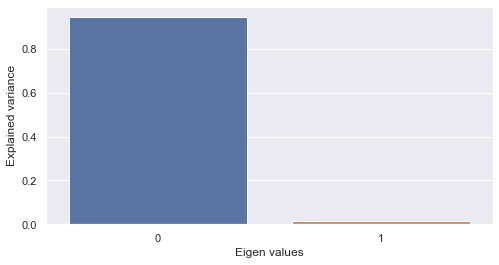

PCA on single-modal explained variance ratio: 0.9603217244148254


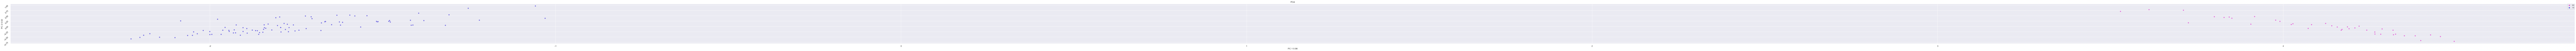

2 clusters -  silhoutte score: 0.8468862771987915 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.4503043293952942 - mutual information: 0.06291340822037277
4 clusters -  silhoutte score: 0.29687151312828064 - mutual information: 0.057216549597027454


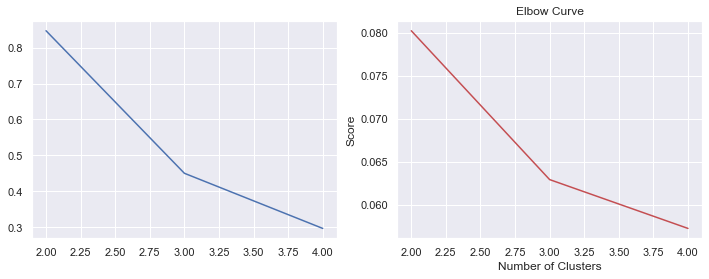

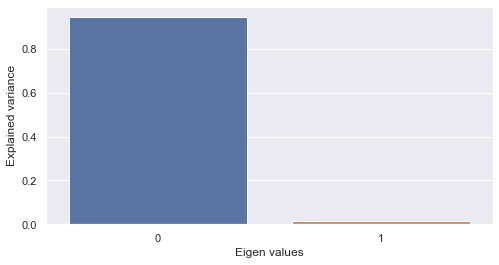

PCA on single-modal explained variance ratio: 0.9603217244148254


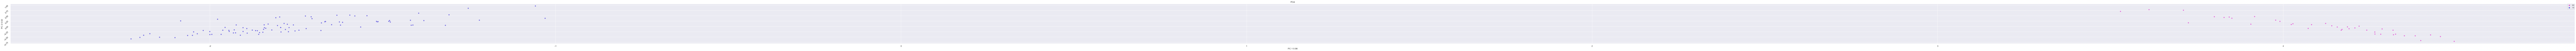

2 clusters -  silhoutte score: 0.8468862771987915 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.6890397071838379 - mutual information: 0.06965299905725833
4 clusters -  silhoutte score: 0.6678206324577332 - mutual information: 0.11674175887931187


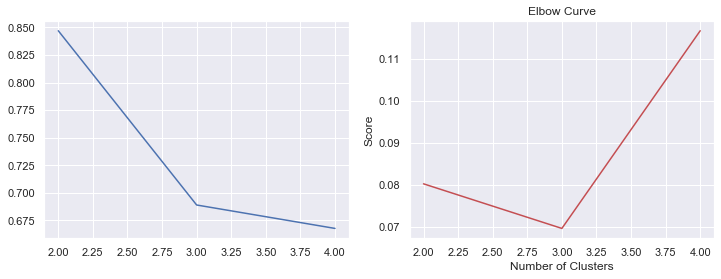

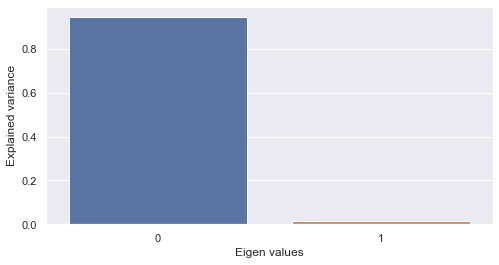

PCA on single-modal explained variance ratio: 0.9603217244148254


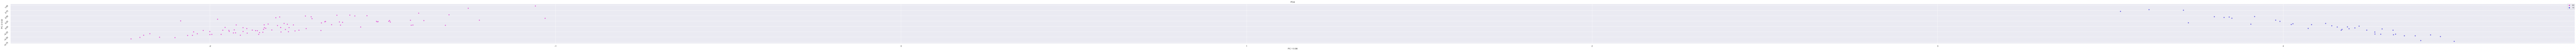

2 clusters -  silhoutte score: 0.8468862771987915 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.4413350522518158 - mutual information: 0.059936835750118274
4 clusters -  silhoutte score: 0.28767961263656616 - mutual information: 0.05454509337950137


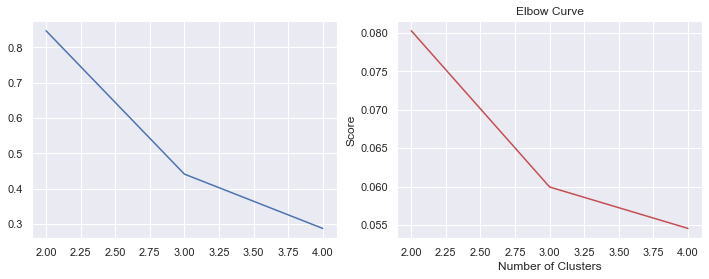

Results for DAE: 

Best score for training data: 0.7153846153846154 

Best C: 0.05 



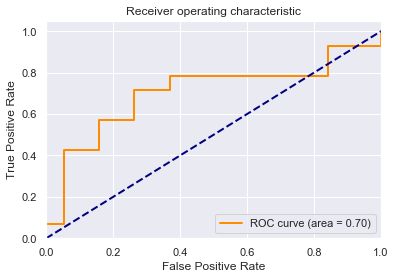

[[16  3]
 [ 7  7]]


              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.70      0.50      0.58        14

    accuracy                           0.70        33
   macro avg       0.70      0.67      0.67        33
weighted avg       0.70      0.70      0.69        33

Training set score for Logistic Regression: 0.715385
Testing  set score for Logistic Regression: 0.696970
Best score for training data: 0.6923076923076923 

Best C: 0.5 

Best Gamma: 0.1 



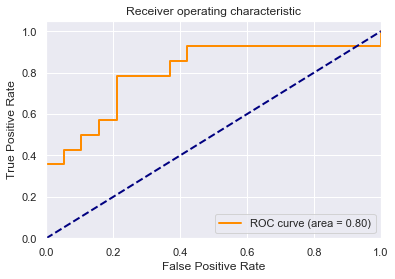

[[16  3]
 [ 7  7]]


              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.70      0.50      0.58        14

    accuracy                           0.70        33
   macro avg       0.70      0.67      0.67        33
weighted avg       0.70      0.70      0.69        33

Training set score for SVM: 0.700000
Testing  set score for SVM: 0.696970
Best score for training data: 0.7153846153846154 

Best #estimators: 80 

Best max depth: 8 



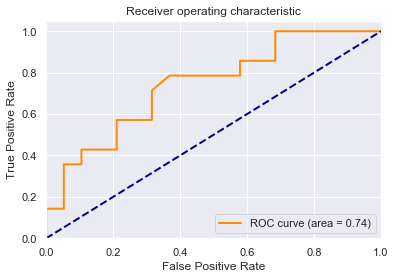

[[17  2]
 [ 8  6]]


              precision    recall  f1-score   support

           0       0.68      0.89      0.77        19
           1       0.75      0.43      0.55        14

    accuracy                           0.70        33
   macro avg       0.72      0.66      0.66        33
weighted avg       0.71      0.70      0.68        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.696970


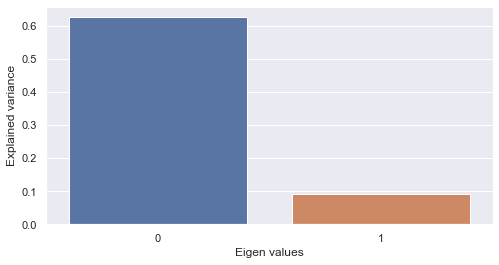

PCA on single-modal explained variance ratio: 0.7157430648803711


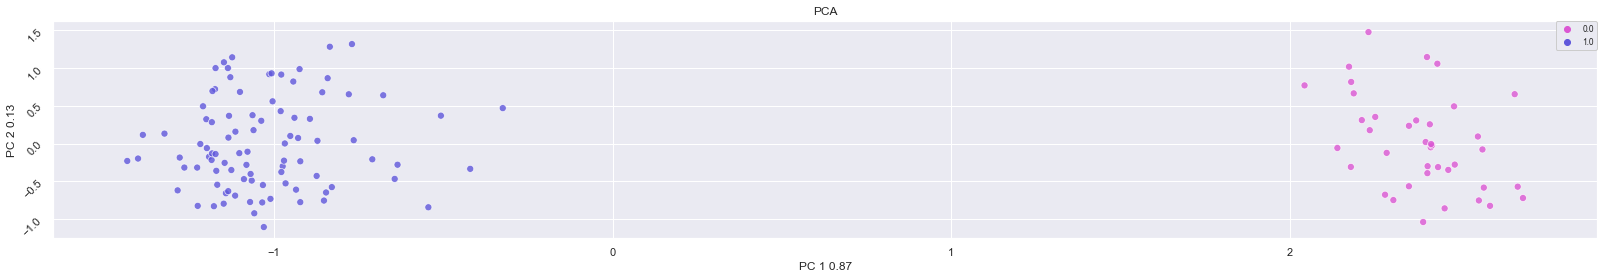

2 clusters -  silhoutte score: 0.5596210360527039 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.2995363175868988 - mutual information: 0.06002105443573342
4 clusters -  silhoutte score: 0.20586422085762024 - mutual information: 0.08074397553541263


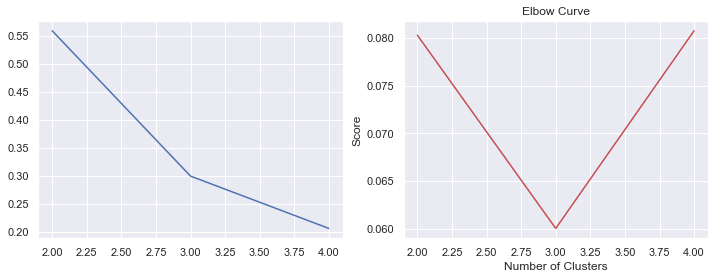

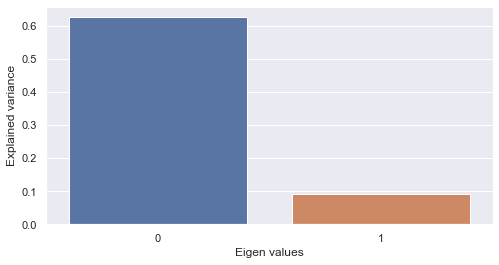

PCA on single-modal explained variance ratio: 0.7157430648803711


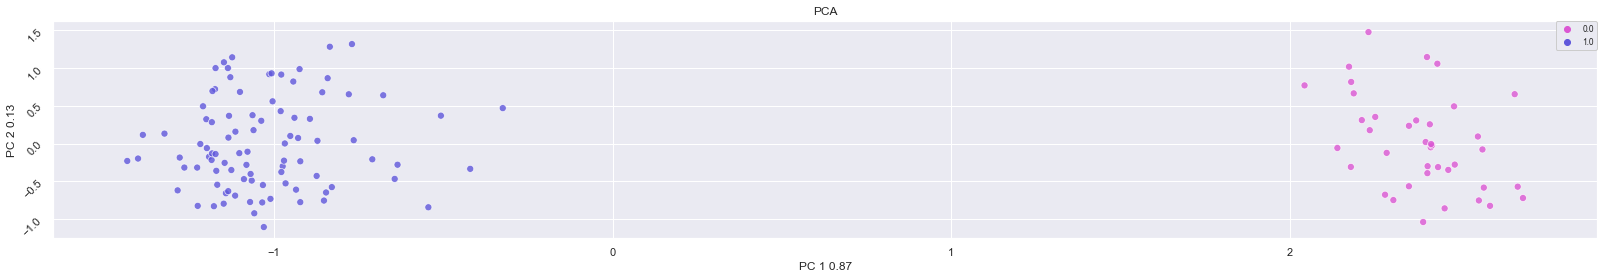

2 clusters -  silhoutte score: 0.5596210360527039 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.4581913650035858 - mutual information: 0.10426316095473105
4 clusters -  silhoutte score: 0.20919376611709595 - mutual information: 0.082077970159413


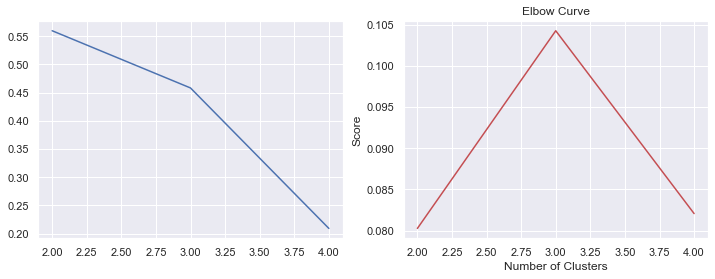

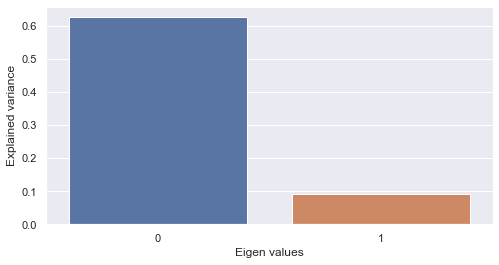

PCA on single-modal explained variance ratio: 0.7157430648803711


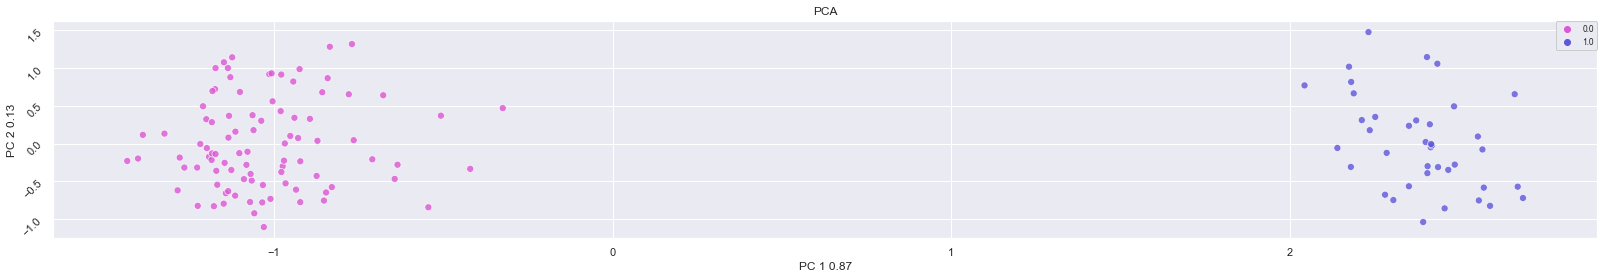

2 clusters -  silhoutte score: 0.5596210360527039 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.27955108880996704 - mutual information: 0.06487618849340038
4 clusters -  silhoutte score: 0.17914165556430817 - mutual information: 0.08656343598107118


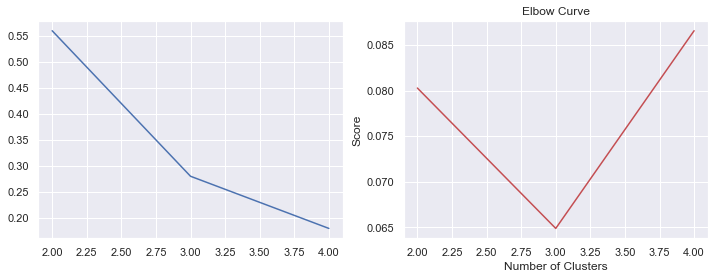

,LR accuracy,SVM accuracy,RF accuracy,LR ROC-AUC,SVM ROC-AUC,RF ROC-AUC,KMeans Silhouette,Spectral Silhouette,Hierarchical Silhouette,KMeans MI,Spectral MI,Hierarchical MI
Multi-AE,0.727273,0.696970,0.696970,0.669173,0.759398,0.706767,0.483139,0.483139,0.483139,0.086904,0.087443,0.086624
AE,0.727273,0.727273,0.757576,0.763158,0.736842,0.635338,0.559621,0.559621,0.559621,0.080744,0.082078,0.086563
Multi-DAE,0.666667,0.727273,0.606061,0.812030,0.751880,0.770677,0.846886,0.846886,0.846886,0.057217,0.116742,0.054545
DAE,0.696970,0.696970,0.696970,0.703008,0.804511,0.742481,0.559621,0.559621,0.559621,0.080744,0.082078,0.086563


No classifier: 0.5757575757575758


In [12]:
## MULTI DAE ##
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_latent_multi_dae, X_latent_test_multi_dae, np.ravel(y_train), np.ravel(y_test), model_type="Multi-DAE")
### CLUSTERING ###
clustering = Models.cluster(X_latent_multi_dae,np.ravel(y_train), model_type="Multi-DAE")

multi_dae_scores = pd.DataFrame([classify + clustering], index=['Multi-DAE'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    

## CONCATENATED DAE ##
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_latent_dae, X_latent_test_dae, np.ravel(y_train), np.ravel(y_test), model_type="DAE")
### CLUSTERING ###
clustering = Models.cluster(X_latent_ae,np.ravel(y_train), model_type="DAE")


dae_scores = pd.DataFrame([classify + clustering], index=['DAE'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
display(pd.concat([multi_ae_scores, ae_scores, multi_dae_scores, dae_scores]))
print(f"No classifier: {y_test.iloc[:,0].value_counts()[0]/len(y_test)}")

Finally, we will obtain the latent space using the KPCA approach. We compute the kernel matrix for each dataset and compute the weighted sum of both matrix to get the total kernel matrix. The hyperparameters for this model are, the kernel function used to compute each kernel matrix, in this case an RBF function, the gamma parameter of the RBF function gamma=0.04 , and the weight parameter $\mu$ = 0.4

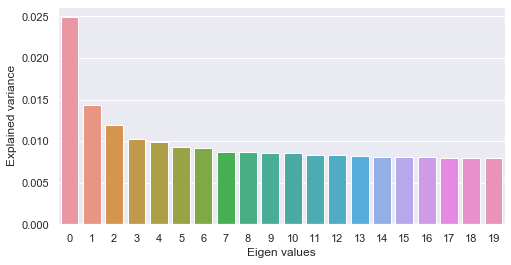

0.08050118188224127


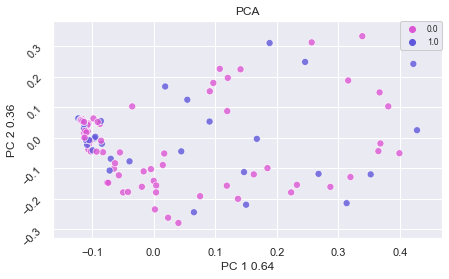

In [16]:
# Apply rbf kernel to divided datasets
X_latent_kpca, X_latent_kpca_test = Models.perform_multi_KPCA(X_train_first_norm, X_train_second_norm, y_train, gamma=0.04, mu=0.4)

Finally, we evaluate the KPCA latent space.

In [18]:
## CONCATENATED KPCA
classify = Models.classify_with_cv(X_latent_kpca, X_latent_kpca_test, np.ravel(y_train), np.ravel(y_test), model_type="KPCA")
### CLUSTERING ###
clustering = Models.cluster(X_latent_kpca,np.ravel(y_train), model_type="KPCA")


kpca_scores = pd.DataFrame([classify + clustering], index=['KPCA'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
display(pd.concat([multi_ae_scores, ae_scores, multi_dae_scores, dae_scores, kpca_scores]))
print(f"No classifier: {y_test.iloc[:,0].value_counts()[0]/len(y_test)}")

Results for KPCA: 

Best score for training data: 0.6 

Best C: 0.0001 



ValueError: Expected 2D array, got scalar array instead:
array=KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='precomputed',
          kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [21]:
X_latent_kpca_test.shape

AttributeError: 'KernelPCA' object has no attribute 'shape'